In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim

In [3]:
df = pd.read_csv(".data/sales_train.csv")
df_items = pd.read_csv(".data/items.csv")
df_shops = pd.read_csv(".data/shops.csv")

In [4]:
df = df.merge(df_items[['item_id', 'item_category_id']], on="item_id", how="left")
df = df.reindex(columns=['date', 'date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_price', 'item_cnt_day'])

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.sort_values(by=['date', 'shop_id', 'item_id']).reset_index(drop=True)

In [6]:
valid_index = (df['date_block_num'] == df['date_block_num'].max())

df_train = df[~valid_index]#.drop(columns=["date_block_num"])
df_valid = df[valid_index]#.drop(columns=["date_block_num"])

In [7]:
uq_shops = df_shops['shop_id'].sort_values().unique()
uq_items = df_items['item_id'].sort_values().unique()
uq_categories = df_items['item_category_id'].sort_values().unique()

In [8]:
def check_arranged_index(arr: np.ndarray) -> bool:
    return (np.arange(0, arr.size) == arr).all()

In [9]:
print(check_arranged_index(uq_shops), check_arranged_index(uq_items), check_arranged_index(uq_categories))

True True True


In [10]:
pd.Series(df_train.groupby(["shop_id", "item_id", "date_block_num"])['item_cnt_day'].sum().values).value_counts()

1.0      1037474
2.0       260432
3.0       101320
4.0        52368
5.0        31392
          ...   
272.0          1
312.0          1
426.0          1
792.0          1
303.0          1
Name: count, Length: 441, dtype: int64

In [11]:
df_train.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

,date,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day
165832,2013-02-15,1,0,30,40,265.0,2.0
169580,2013-02-16,1,0,30,40,265.0,9.0
175269,2013-02-17,1,0,30,40,265.0,4.0
180336,2013-02-18,1,0,30,40,265.0,4.0
186528,2013-02-20,1,0,30,40,265.0,2.0
...,...,...,...,...,...,...,...
2758268,2015-07-21,30,59,22164,37,699.0,1.0
1008514,2013-10-25,9,59,22167,49,299.0,1.0
1132842,2013-12-03,11,59,22167,49,299.0,1.0
1171425,2013-12-14,11,59,22167,49,299.0,1.0


In [12]:
df_train_monthly = df_train.groupby(["shop_id", "item_id", "date_block_num"])['item_cnt_day'].sum().reset_index()
df_train_monthly['item_cnt_day'] = df_train_monthly['item_cnt_day'].clip(0, 20)

In [13]:
df_train_monthly

,shop_id,item_id,date_block_num,item_cnt_day
0,0,30,1,20.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0
...,...,...,...,...
1577588,59,22164,27,2.0
1577589,59,22164,30,1.0
1577590,59,22167,9,1.0
1577591,59,22167,11,2.0


In [14]:
def create_series_vectors(x: pd.DataFrame, MAX: int = df_train_monthly['date_block_num'].max() + 1) -> np.ndarray:
    v = np.zeros(MAX)
    v[x['date_block_num'].values] = x['item_cnt_day'].values

    return v

In [15]:
tst = pd.DataFrame([[0, 10], [3, 20], [4, 7]], columns=['date_block_num', 'item_cnt_day'])

create_series_vectors(tst)

array([10.,  0.,  0., 20.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [16]:
df_train_monthly_series = df_train_monthly.groupby(["shop_id", "item_id"]) \
    .apply(create_series_vectors) \
    .reset_index() \
    .rename(columns={0: 'monthly_sales_array'}, inplace=False)

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_56136/1374034082.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(create_series_vectors) \


In [17]:
df_train_monthly_series = df_train_monthly_series.merge(df_items[['item_id', 'item_category_id']], on="item_id", how="left")
df_train_monthly_series = df_train_monthly_series.reindex(columns=['shop_id', 'item_id', 'item_category_id', 'monthly_sales_array'])

In [18]:
df_train_monthly_series

,shop_id,item_id,item_category_id,monthly_sales_array
0,0,30,40,"[0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,31,37,"[0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,32,40,"[6.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,33,37,"[3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,35,40,"[1.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...
416999,59,22154,37,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
417000,59,22155,37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
417001,59,22162,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
417002,59,22164,37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
df_valid_monthly = df_valid.groupby(["shop_id", "item_id", "date_block_num"])['item_cnt_day'].sum().reset_index()
df_valid_monthly['item_cnt_day'] = df_valid_monthly['item_cnt_day'].clip(0, 20)
df_valid_monthly = df_valid_monthly.drop(columns=["date_block_num"])

In [20]:
df_final = df_train_monthly_series.merge(df_valid_monthly, on=["shop_id", "item_id"], how="left").rename(columns={'item_cnt_day': 'y'}, inplace=False)

In [21]:
df_final = df_final[df_final['y'].notna()]

In [22]:
X = df_final.drop(columns=["y"])
y = df_final['y'].values

In [23]:
X

,shop_id,item_id,item_category_id,monthly_sales_array
6125,2,31,37,"[0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6148,2,486,73,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6167,2,787,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6219,2,1075,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6247,2,1377,23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
416975,59,22087,83,"[9.0, 1.0, 6.0, 0.0, 2.0, 17.0, 12.0, 7.0, 10...."
416976,59,22088,83,"[5.0, 0.0, 5.0, 3.0, 6.0, 8.0, 7.0, 4.0, 4.0, ..."
416977,59,22091,83,"[0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 7.0, 2.0, 0.0, ..."
416979,59,22100,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
class SalesPredictionModel(nn.Module):
    def __init__(self, num_shops, num_items, num_categories, embedding_size, sales_vector_size):
        super(SalesPredictionModel, self).__init__()
        
        # Embedding layers for categorical variables
        self.shop_embedding = nn.Embedding(num_embeddings=num_shops, embedding_dim=embedding_size)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        self.category_embedding = nn.Embedding(num_embeddings=num_categories, embedding_dim=embedding_size)
        
        # Fully connected layers
        input_size = embedding_size * 3 + sales_vector_size  # 3 embeddings + sales vector size
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        
        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, shop_id, item_id, category_id, sales_array):
        # Pass categorical inputs through their respective embeddings
        shop_embed = self.shop_embedding(shop_id).squeeze(1)
        item_embed = self.item_embedding(item_id).squeeze(1)
        category_embed = self.category_embedding(category_id).squeeze(1)
        
        # Concatenate all embeddings with the sales array
        concatenated = torch.cat([shop_embed, item_embed, category_embed, sales_array], dim=1)
        
        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(concatenated))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        
        # Output layer with sigmoid scaled to 0-20
        output = self.sigmoid(self.output(x)) * 20
        
        return output

In [25]:
# Parameters
num_shops = uq_shops.size        # Example: total unique shops
num_items = uq_items.size        # Example: total unique items
num_categories = uq_categories.size    # Example: total unique categories
embedding_size = 8     # Embedding size for each categorical feature
sales_vector_size = X.iloc[0]['monthly_sales_array'].size  # Size of the monthly_sales_array (fixed size)

# Instantiate the model
model = SalesPredictionModel(num_shops, num_items, num_categories, embedding_size, sales_vector_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [26]:
class SalesDataset(Dataset):
    def __init__(self, df):
        # Convert DataFrame columns to PyTorch tensors
        self.shop_ids = torch.tensor(df['shop_id'].values, dtype=torch.long).unsqueeze(1)
        self.item_ids = torch.tensor(df['item_id'].values, dtype=torch.long).unsqueeze(1)
        self.category_ids = torch.tensor(df['item_category_id'].values, dtype=torch.long).unsqueeze(1)
        self.sales_array = torch.tensor(np.vstack(df['monthly_sales_array'].values), dtype=torch.float32)
        self.targets = torch.tensor(df['y'].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.shop_ids)

    def __getitem__(self, idx):
        return (self.shop_ids[idx], self.item_ids[idx], self.category_ids[idx], self.sales_array[idx], self.targets[idx])

# Instantiate the dataset
dataset = SalesDataset(df=df_final)


In [27]:
train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)

# Create datasets
train_dataset = SalesDataset(train_df)
val_dataset = SalesDataset(val_df)

# Create DataLoaders for train and validation sets
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [28]:
train_df

,shop_id,item_id,item_category_id,monthly_sales_array,y
316537,47,7534,55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
314860,47,3077,23,"[1.0, 2.0, 4.0, 6.0, 2.0, 4.0, 4.0, 4.0, 6.0, ...",1.0
261365,39,15048,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0
17114,4,3633,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
409264,58,20644,72,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...,...,...,...
378084,55,8039,31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0
110851,19,2875,25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
20549,4,13968,55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
271525,42,2592,55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [29]:
val_df

,shop_id,item_id,item_category_id,monthly_sales_array,y
245343,37,6342,55,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
131337,22,4869,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
267966,41,14436,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
356730,53,4357,30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
153955,25,9411,70,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...,...,...,...
313017,46,19507,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
329814,50,1877,20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
219608,31,11468,40,"[1.0, 2.0, 3.0, 3.0, 4.0, 4.0, 2.0, 1.0, 1.0, ...",1.0
299053,45,4424,55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [30]:
num_epochs = 10

history = {
    'train_loss': [],
    'val_loss': []
}

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        shop_ids, item_ids, category_ids, sales_arrays, targets = batch
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            shop_ids, item_ids, category_ids, sales_arrays, targets = batch
            
            # Forward pass
            predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
            
            # Compute loss
            loss = criterion(predictions, targets)
            val_loss += loss.item()

    history['train_loss'].append(running_loss / len(train_loader))    
    history['val_loss'].append(val_loss / len(val_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

Epoch [1/10], Train Loss: 13.283168790130183, Val Loss: 6.729638052430559
Epoch [2/10], Train Loss: 3.954379237879988, Val Loss: 3.1807550725979814
Epoch [3/10], Train Loss: 2.5909670899907913, Val Loss: 2.844708474935223
Epoch [4/10], Train Loss: 2.350111862379769, Val Loss: 2.70937789957696
Epoch [5/10], Train Loss: 2.2014115055597974, Val Loss: 2.609852521355628
Epoch [6/10], Train Loss: 2.1001844480832133, Val Loss: 2.502241288355983
Epoch [7/10], Train Loss: 2.0263991494606213, Val Loss: 2.4748153597811533
Epoch [8/10], Train Loss: 1.9728384163522148, Val Loss: 2.419515006347832
Epoch [9/10], Train Loss: 1.9150148010517012, Val Loss: 2.421191821426592
Epoch [10/10], Train Loss: 1.8800308835196329, Val Loss: 2.3603018568843943


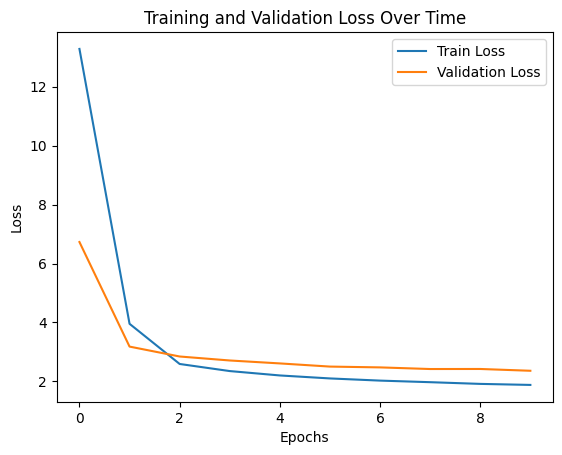

In [31]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [32]:
preds = []

with torch.no_grad():
    for i in range(len(val_dataset)):
        elem = (_.unsqueeze(0) for _ in val_dataset[i])
        shop_ids, item_ids, category_ids, sales_arrays, targets = elem

        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        preds.append(predictions.item())

In [33]:
val_df_preds = val_df.copy().assign(predictions=preds)

In [34]:
val_df_preds

,shop_id,item_id,item_category_id,monthly_sales_array,y,predictions
245343,37,6342,55,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.351531
131337,22,4869,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.252724
267966,41,14436,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.087250
356730,53,4357,30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.978631
153955,25,9411,70,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,2.550397
...,...,...,...,...,...,...
313017,46,19507,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.229608
329814,50,1877,20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.889030
219608,31,11468,40,"[1.0, 2.0, 3.0, 3.0, 4.0, 4.0, 2.0, 1.0, 1.0, ...",1.0,3.040385
299053,45,4424,55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.960857
